In [104]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [72]:
df = pd.read_csv("../data/stock_data.csv")

In [73]:
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [74]:
df.shape

(5791, 2)

In [75]:
X_train, X_test = df[:5700], df[5700:]
X_test

,Text,Sentiment
5700,"Sensex, Nifty Likely To Start Session Sharply ...",-1
5701,RBI To Buy Government Bonds In Open Markets To...,1
5702,Banks Shelve Fundraising As Coronavirus Derail...,-1
5703,"Sensex, Nifty Crash 15% In Three Trading Sessi...",-1
5704,"Gold Futures Drop Over 2% To Rs 39,354 Per 10 ...",-1
...,...,...
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [76]:
# Convert seentiment to numeric. In this case, 0 for positive and 1 for negative
sentiment_label = df.Sentiment.factorize()
sentiment_label

(array([0, 0, 0, ..., 0, 0, 0]), Int64Index([1, -1], dtype='int64'))

In [77]:
# Assign a number to each word and replace with that number in the sentence

# Get the actual texts from the data frame
review = X_train.Text.values
# Initialize the tokenizer with a 5000 word limit. This is the number of words we would like to encode
tokenizer = Tokenizer(num_words=5000)
# Call fit_on_texts to create associations of words and numbers as shown in the image below.
tokenizer.fit_on_texts(review)

vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(review)
# As the model input requires to have equal length, the sequence is padded to have a length
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [78]:
# Review and the corresponding numeric representation of it
print(review[0][:200])
print(padded_sequence[0])

Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  

In [79]:
# Build the model

embedding_vector_length = 32

model = Sequential()

model.add(Embedding(vocab_size, embedding_vector_length, input_length=len(padded_sequence[0])))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 32)           321344    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 337,995
Trainable params: 337,995
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
history = model.fit(padded_sequence,sentiment_label[0],
                  validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
143/143 [==============================] - 30s 187ms/step - loss: 0.6471 - accuracy: 0.6576 - val_loss: 0.7711 - val_accuracy: 0.4798
Epoch 2/5
143/143 [==============================] - 29s 205ms/step - loss: 0.4918 - accuracy: 0.7507 - val_loss: 0.6637 - val_accuracy: 0.5930
Epoch 3/5
143/143 [==============================] - 25s 177ms/step - loss: 0.3628 - accuracy: 0.8525 - val_loss: 1.0387 - val_accuracy: 0.5632
Epoch 4/5
143/143 [==============================] - 26s 183ms/step - loss: 0.2781 - accuracy: 0.8870 - val_loss: 0.8834 - val_accuracy: 0.6246
Epoch 5/5
143/143 [==============================] - 27s 186ms/step - loss: 0.2155 - accuracy: 0.9174 - val_loss: 0.8951 - val_accuracy: 0.6272


In [ ]:
model.save('./twitter_sentiment_analyzer')

In [81]:
def analyze_sentence(sentence):
    tw = tokenizer.texts_to_sequences([sentence])
    tw = pad_sequences(tw, maxlen=200)
    pred = model.predict(tw)
    prediction = int(pred.round().item())
    print(pred)
    if sentiment_label[1][prediction] == 1: 
        return 'positive' 
    else: 
        return 'negative'

'Sensex, Nifty Likely To Start Session Sharply Lower In Gap-Down Opening\nhttps://t.co/rrH5C0GMs5'

In [123]:
print(analyze_sentence(X_test.values[0][0]))



[[0.94275415]]
negative


In [113]:
def analyze_sentence2(sentence:str, sentiment_score:int, serie):
    if sentiment_score == -1:
        sentiment_score = 0
    serie[0].append(sentiment_score)
    
    tw = tokenizer.texts_to_sequences([sentence])
    tw = pad_sequences(tw, maxlen=200)
    pred = model.predict(tw)
    prediction = int(pred.round().item())
    serie[1].append(pred[0])
    return sentiment_label[1][prediction]

series = [[],[]]
for text, sentiment in X_test.values:
    analyze_sentence2(text, sentiment, series)


Text(0.5, 1.0, 'Test Dataset')

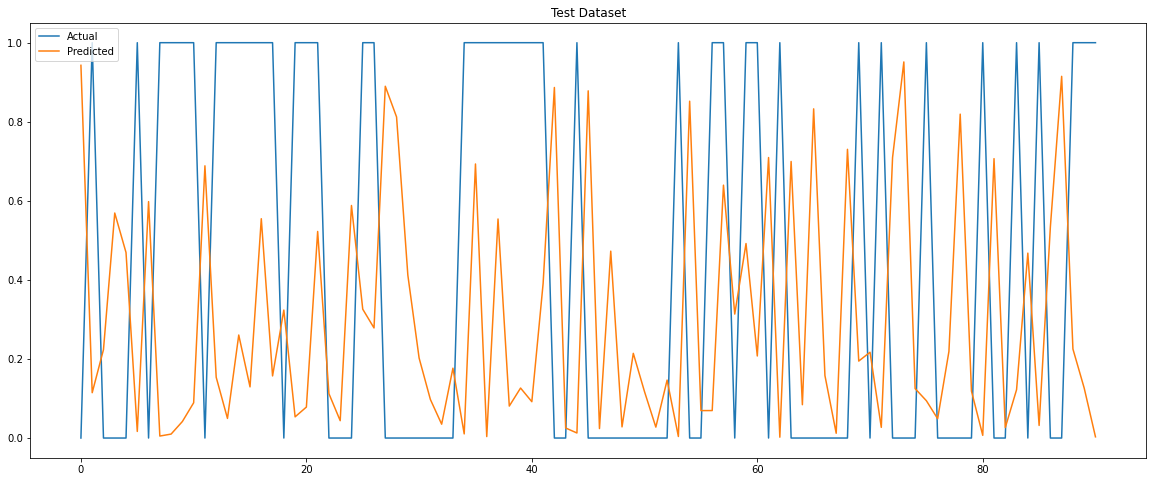

In [130]:
plt.figure(figsize=(20,8))

#Xt = model.predict(X_test)
#ax=[[series[0], series[1]]].plot()

plt.plot(series[0], label="Actual")
plt.plot(series[1], label="Predicted")
plt.legend()
plt.title("Test Dataset")